# U.S. Presidential Election

## Libraries

In [1]:
import warnings
warnings.simplefilter('ignore')

import requests
import lxml.html as lh

import sys

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

import networkx as nx

sys.path.append('..')
from lmapper.filter import Projection
from lmapper.filter import Filter

from lmapper.cutoff import FirstGap

from utils import get_node_size, get_mean_node, get_mapper
from filters import SvdFilter, LpFilter
from plotting import nx_plot_mapper, county_plot

../lmapper/cpp/filterutils


The Python implementation of the eccentricity is used instead, but it will be slower.
The scipy.distance.cdist implementation is used instead.


In [2]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",
                                                           ["blue", "violet", "red"])
cmap_inv = matplotlib.colors.LinearSegmentedColormap.from_list("",
                                                               ["red", "violet", "blue"])

## Data

In [3]:
df = pd.read_pickle(os.path.join('data',
                                  'usa_election_full_dataset.pickle'))

df.head()

,year,state,county,fips,pres,republican,democrat,total_votes,winner,Personal income (thousands of dollars),...,Farm proprietors' income,Nonfarm proprietors' income,Total employment (number of jobs),Wage and salary employment,Proprietors employment,Farm proprietors employment 6/,Nonfarm proprietors employment,Average earnings per job (dollars),Average wages and salaries,Average nonfarm proprietors' income
0,2000,Alabama,Autauga,01001,1,11993.0,4942.0,17208.0,1,1042400.0,...,8519.0,54075.0,16138.0,11884.0,4254.0,404.0,3850.0,25707.0,24447.0,14045.0
1,2004,Alabama,Autauga,01001,1,15196.0,4758.0,20081.0,1,1332117.0,...,14696.0,66346.0,16884.0,12572.0,4312.0,324.0,3988.0,30129.0,27272.0,16636.0
2,2008,Alabama,Autauga,01001,0,17403.0,6093.0,23641.0,1,1750849.0,...,5556.0,50773.0,17802.0,12562.0,5240.0,357.0,4883.0,30096.0,30792.0,10398.0
3,2012,Alabama,Autauga,01001,0,17379.0,6363.0,23932.0,1,1927064.0,...,4304.0,81871.0,16421.0,11446.0,4975.0,345.0,4630.0,34382.0,33766.0,17683.0
4,2016,Alabama,Autauga,01001,1,18172.0,5936.0,24973.0,1,2185415.0,...,932.0,89807.0,17431.0,12101.0,5330.0,334.0,4996.0,36979.0,36564.0,17976.0


In [4]:
'''
county_plot(fips=df['fips'][df['year'] == 2000].tolist(),
            values=df['winner'][df['year'] == 2000].tolist(),
            colorscale=["#0000ff", "#ff0000"],
            legend_title='Republican/Democrat')
'''

'\ncounty_plot(fips=df[\'fips\'][df[\'year\'] == 2000].tolist(),\n            values=df[\'winner\'][df[\'year\'] == 2000].tolist(),\n            colorscale=["#0000ff", "#ff0000"],\n            legend_title=\'Republican/Democrat\')\n'

In [5]:
num_cols = ['Personal income (thousands of dollars)',
            'Net earnings by place of residence',
            'Personal current transfer receipts',
            'Income maintenance benefits 1/',
            'Unemployment insurance compensation',
            'Retirement and other',
            'Dividends, interest, and rent 2/',
            'Population (persons) 3/',
            'Per capita personal income 4/',
            'Per capita net earnings 4/',
            'Per capita personal current transfer receipts 4/',
            'Per capita income maintenance benefits 4/',
            'Per capita unemployment insurance compensation 4/',
            'Per capita retirement and other 4/',
            'Per capita dividends, interest, and rent 4/',
            'Earnings by place of work',
            'Wages and salaries',
            'Supplements to wages and salaries',
            'Employer contributions for employee pension and insurance funds 5/',
            'Employer contributions for government social insurance',
            "Proprietors' income",
            "Farm proprietors' income",
            "Nonfarm proprietors' income",
            'Total employment (number of jobs)',
            'Wage and salary employment',
            'Proprietors employment',
            'Farm proprietors employment 6/',
            'Nonfarm proprietors employment',
            'Average earnings per job (dollars)',
            'Average wages and salaries',
            "Average nonfarm proprietors' income"]

info_cols = ['year', 'state', 'county', 'fips', 'pres']

elec_cols = ['republican', 'democrat', 'total_votes',
             'winner']

In [6]:
df[num_cols] = (df[num_cols] + abs(df[num_cols].min().min()) + 1).apply(np.log)
df.describe()

,year,pres,republican,democrat,total_votes,winner,Personal income (thousands of dollars),Net earnings by place of residence,Personal current transfer receipts,Income maintenance benefits 1/,...,Farm proprietors' income,Nonfarm proprietors' income,Total employment (number of jobs),Wage and salary employment,Proprietors employment,Farm proprietors employment 6/,Nonfarm proprietors employment,Average earnings per job (dollars),Average wages and salaries,Average nonfarm proprietors' income
count,15219.000000,15219.000000,1.521900e+04,1.521900e+04,1.521900e+04,15219.000000,15219.000000,15219.000000,15219.000000,15219.000000,...,15219.000000,15219.000000,15219.000000,15219.000000,15219.000000,15219.000000,15219.000000,15219.000000,15219.000000,15219.000000
mean,2008.000526,0.599974,1.902383e+04,1.987288e+04,4.002186e+04,0.792431,15.879133,15.797376,15.655983,15.585140,...,15.577582,15.617306,15.584225,15.582408,15.576918,15.575068,15.576810,15.581245,15.580577,15.578742
std,5.656854,0.489919,4.417210e+04,7.188497e+04,1.153326e+05,0.405580,0.480850,0.400781,0.166362,0.035243,...,0.007068,0.143276,0.028804,0.023913,0.006599,0.000088,0.006588,0.001880,0.001513,0.002624
min,2000.000000,0.000000,5.400000e+01,4.000000e+00,6.400000e+01,0.000000,15.575374,15.575083,15.575003,15.574960,...,15.554932,9.266815,15.574969,15.574964,15.574965,15.574960,15.574963,15.575524,15.577501,15.566147
25%,2004.000000,0.000000,2.883000e+03,1.559500e+03,4.753000e+03,1.000000,15.628020,15.605786,15.587354,15.575989,...,15.574966,15.578283,15.575831,15.575549,15.575228,15.575011,15.575151,15.579987,15.579531,15.577555
50%,2008.000000,1.000000,6.273000e+03,3.880000e+03,1.053500e+04,1.000000,15.696609,15.649206,15.603557,15.577609,...,15.575922,15.583270,15.577037,15.576482,15.575504,15.575049,15.575391,15.581020,15.580407,15.578265
75%,2012.000000,1.000000,1.574450e+04,1.051250e+04,2.718700e+04,1.000000,15.884694,15.776808,15.645617,15.581722,...,15.578209,15.599125,15.580600,15.579282,15.576229,15.575101,15.576077,15.582170,15.581322,15.579250
max,2016.000000,1.000000,1.076225e+06,2.464364e+06,3.434308e+06,1.000000,20.185349,19.709058,18.442908,16.649595,...,15.793969,18.140522,16.314220,16.165203,15.829570,15.576214,15.829445,15.598275,15.595015,15.649573


In [7]:
'''
q1 = df[cols].quantile(0.25)
q3 = df[cols].quantile(0.75)
iqr = q3 - q1

outliers = ((df[cols] < (q1 - 1.5 * iqr)) |
            (df[cols] > (q3 + 1.5 * iqr))).any(axis=1)

df = df.drop(outliers.where(outliers == True).dropna().index,
             axis=0).reset_index(drop=True)
'''

'\nq1 = df[cols].quantile(0.25)\nq3 = df[cols].quantile(0.75)\niqr = q3 - q1\n\noutliers = ((df[cols] < (q1 - 1.5 * iqr)) |\n            (df[cols] > (q3 + 1.5 * iqr))).any(axis=1)\n\ndf = df.drop(outliers.where(outliers == True).dropna().index,\n             axis=0).reset_index(drop=True)\n'

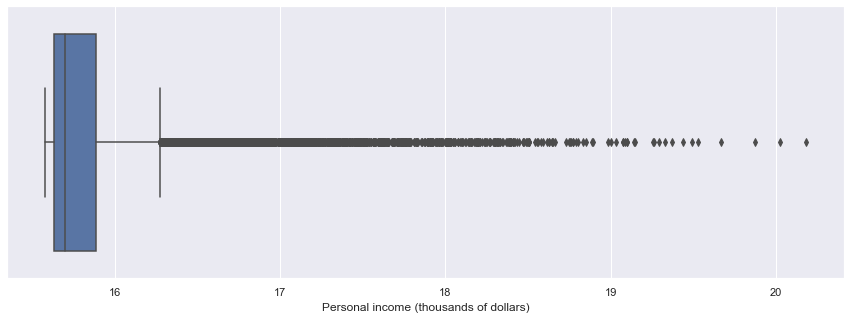

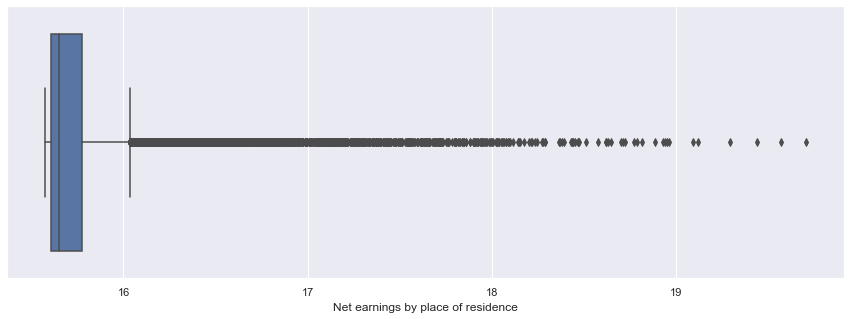

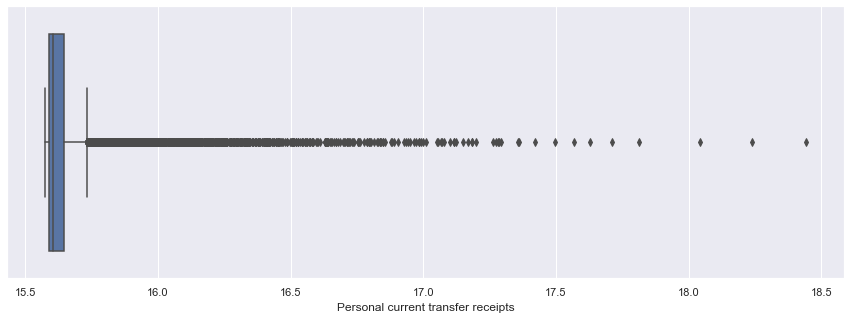

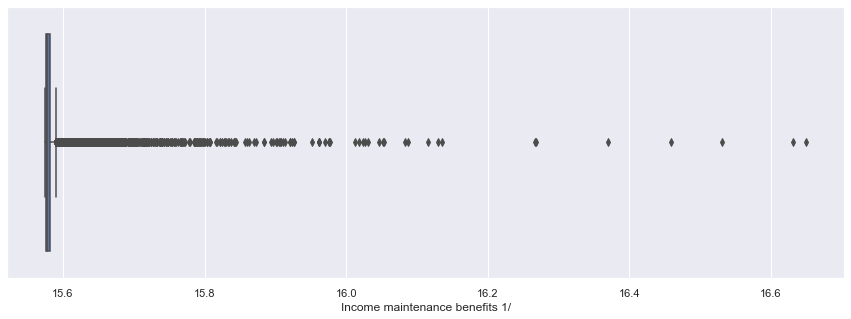

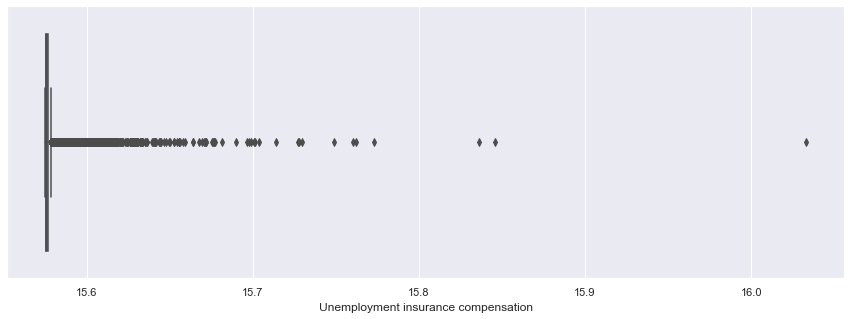

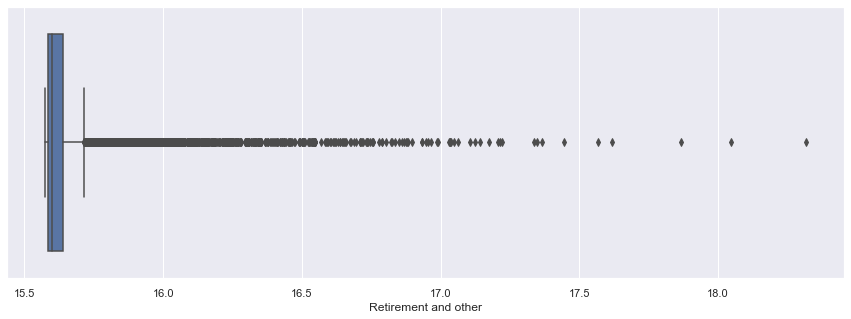

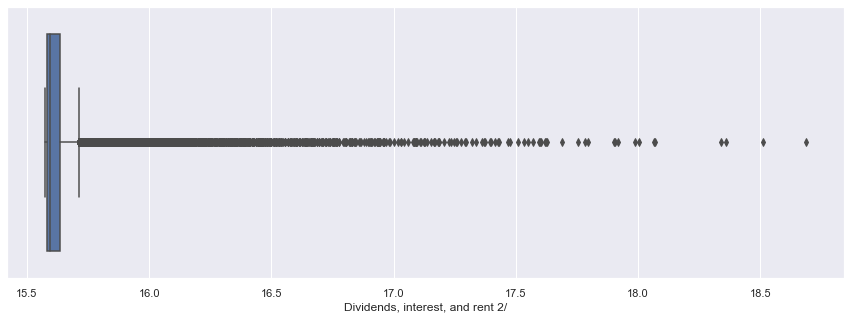

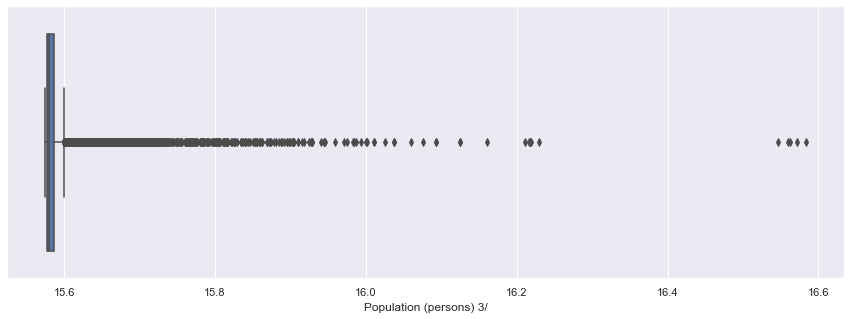

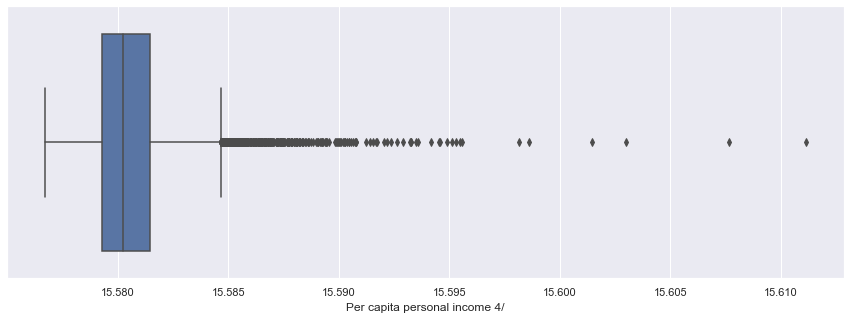

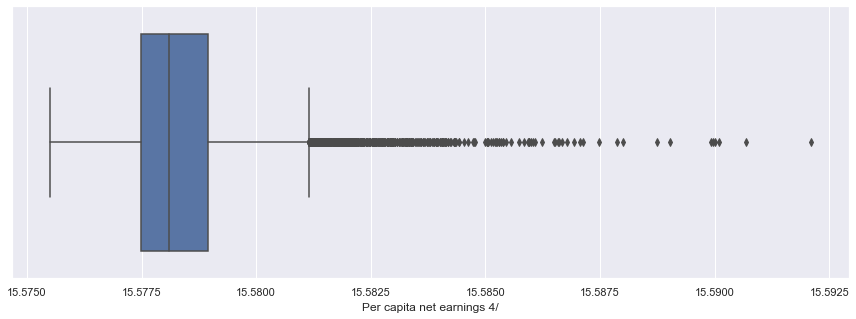

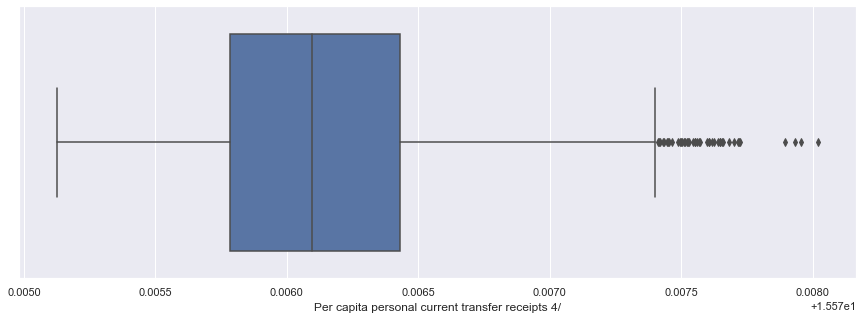

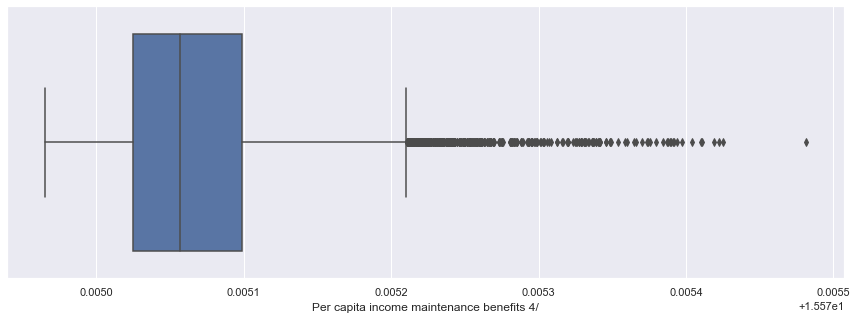

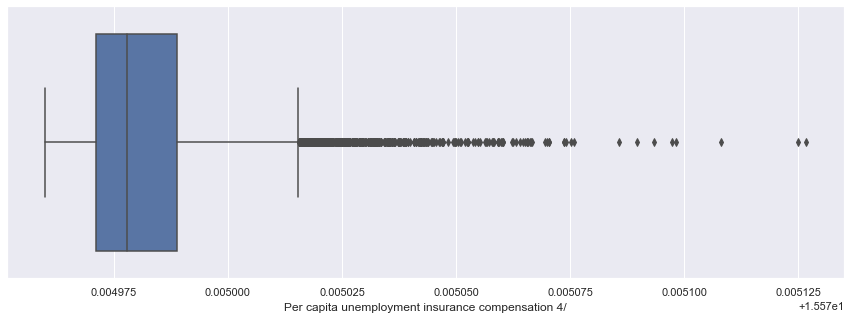

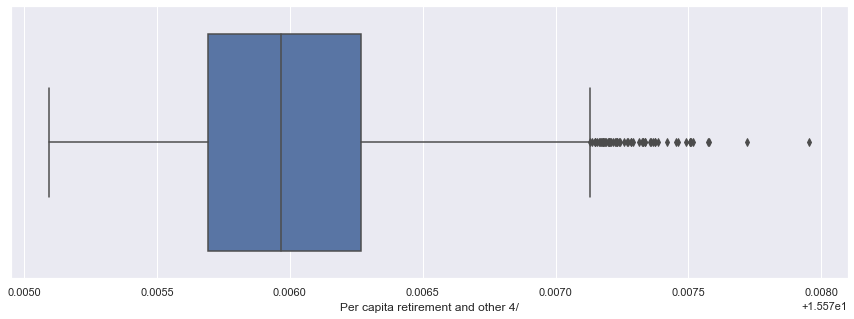

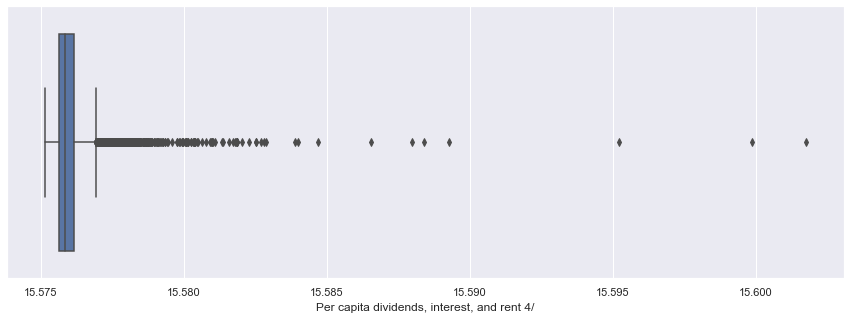

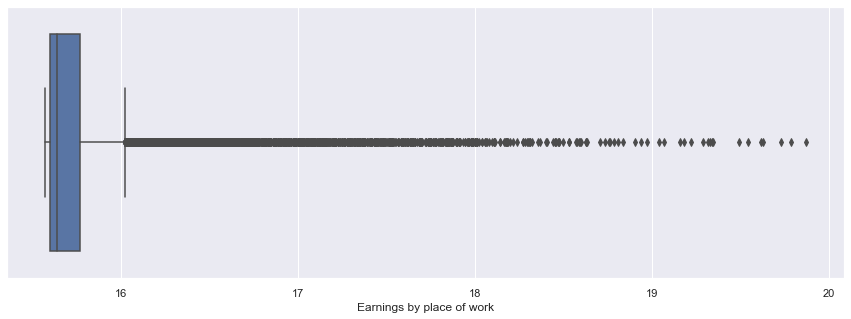

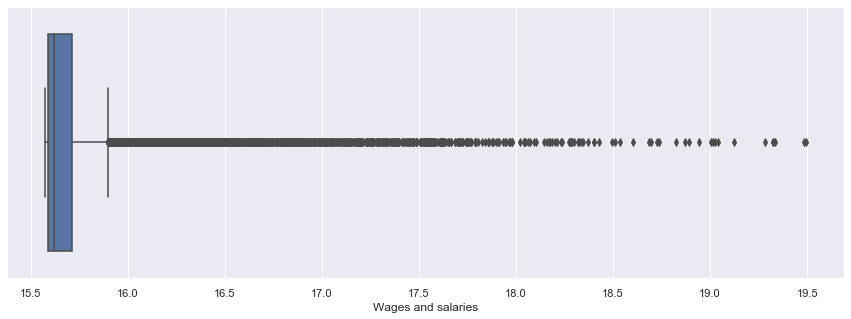

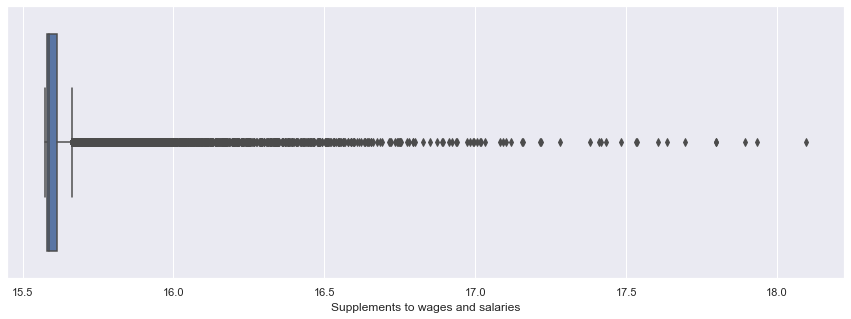

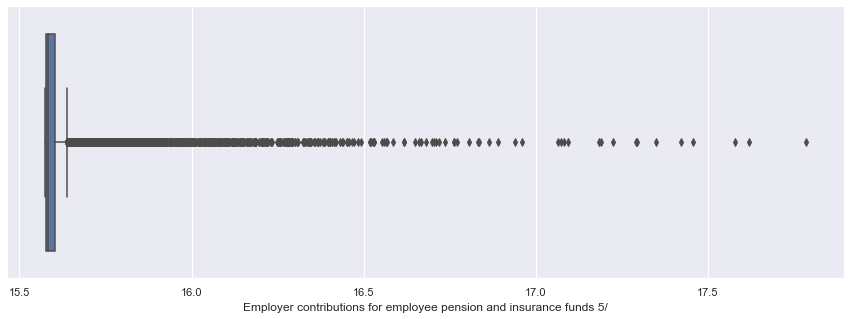

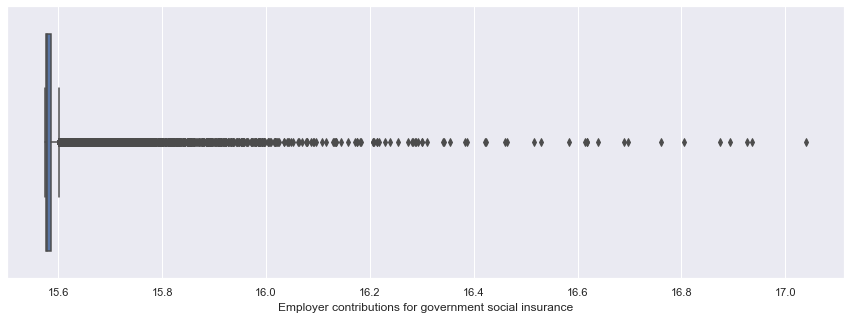

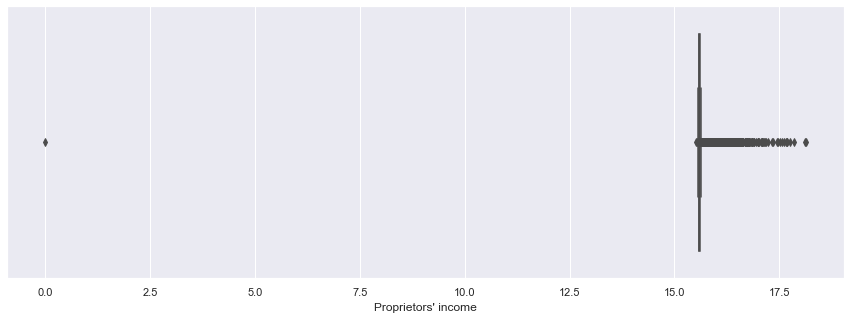

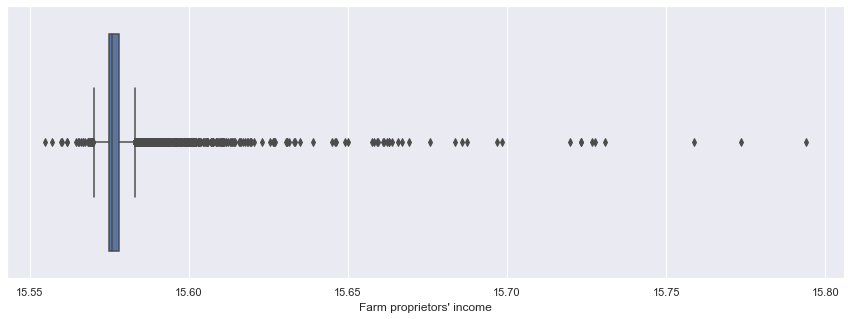

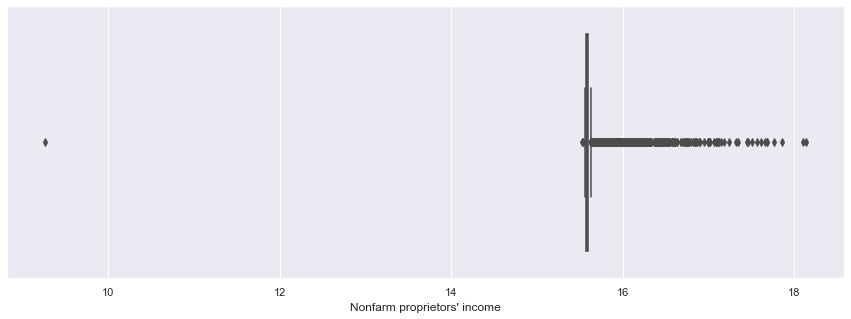

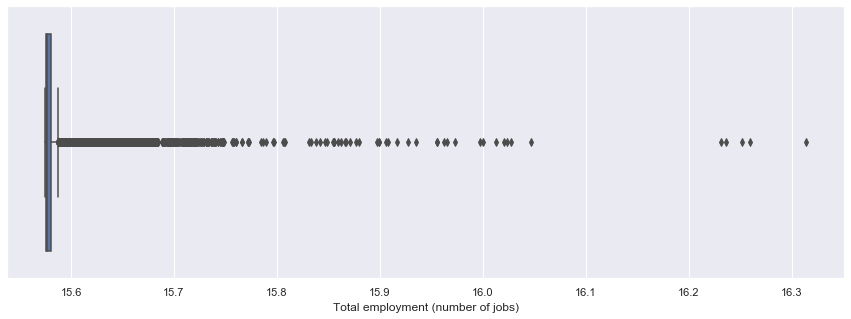

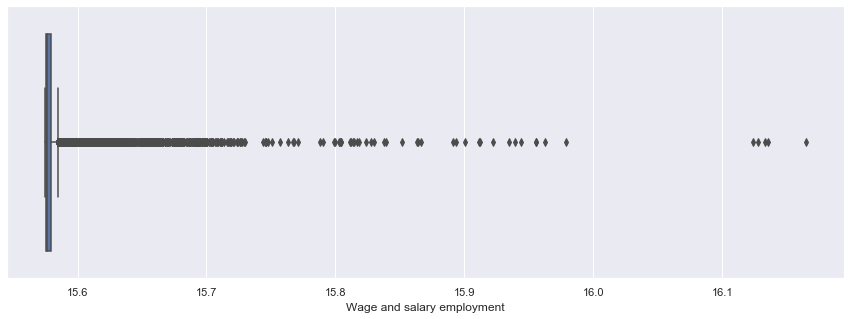

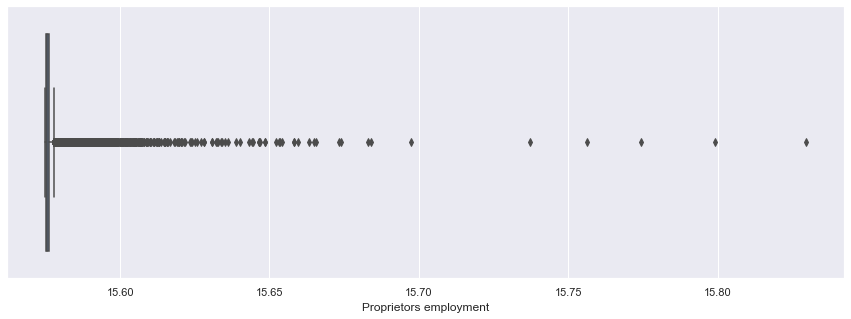

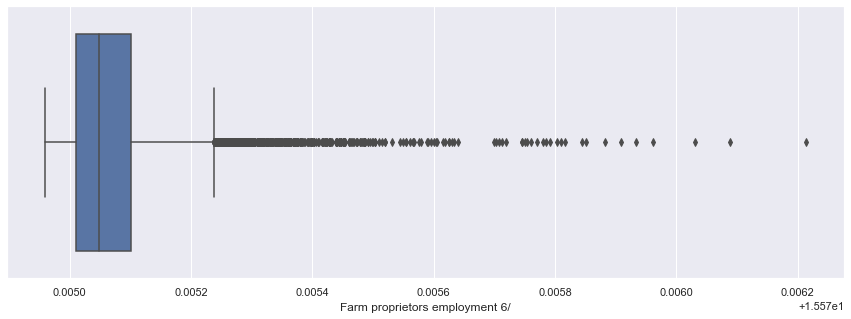

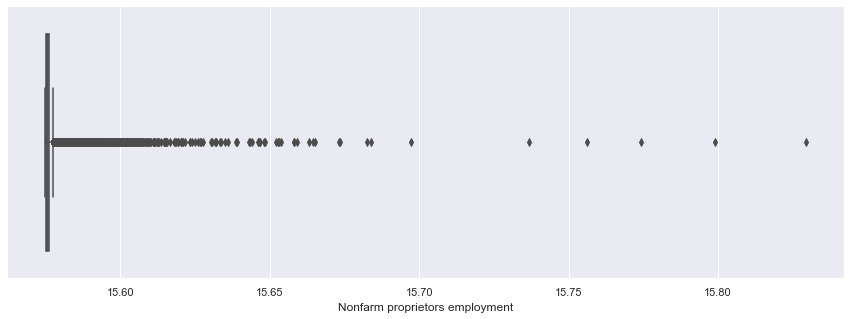

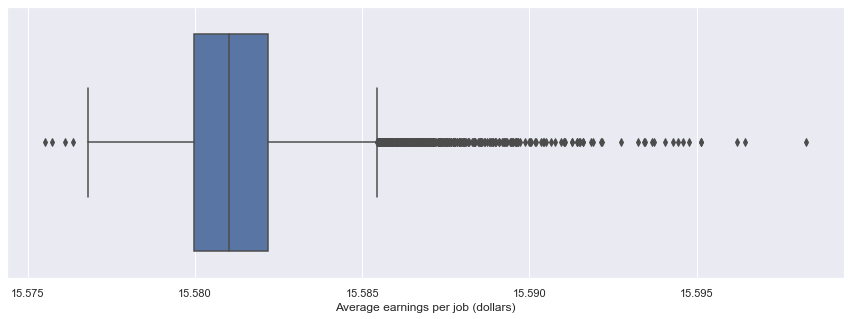

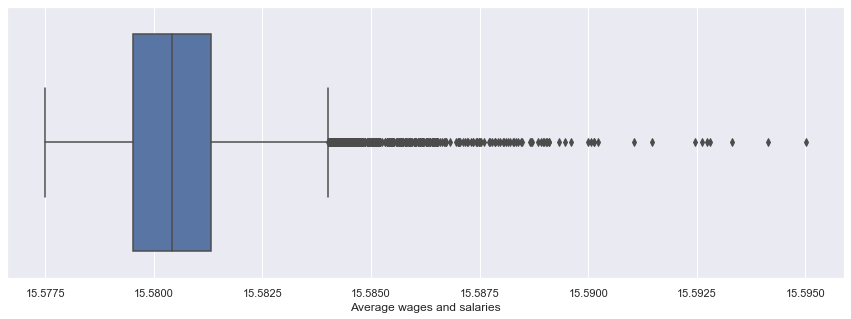

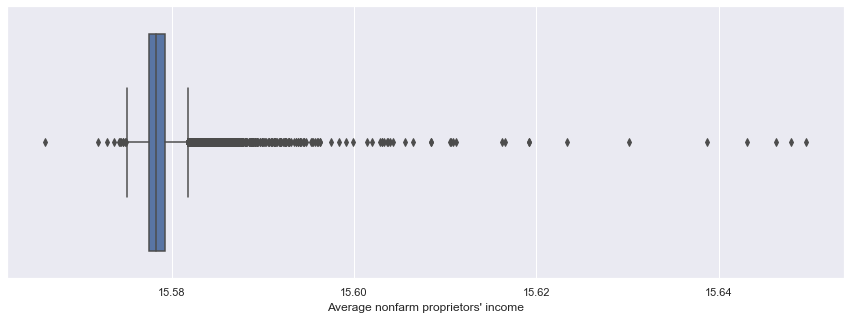

In [8]:
for col in num_cols:
    plt.figure(figsize=(15, 5))
    sns.boxplot(x=df[col])

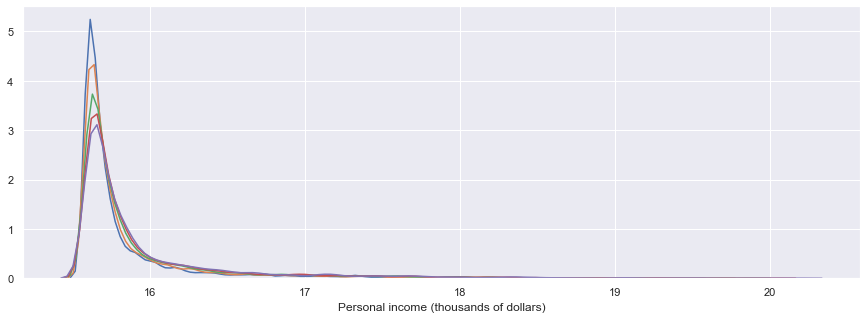

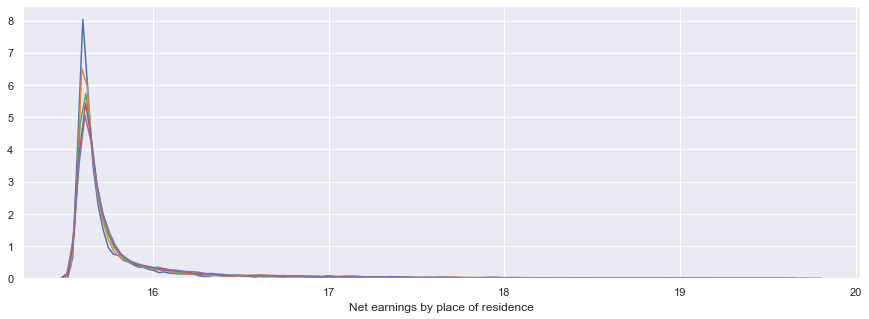

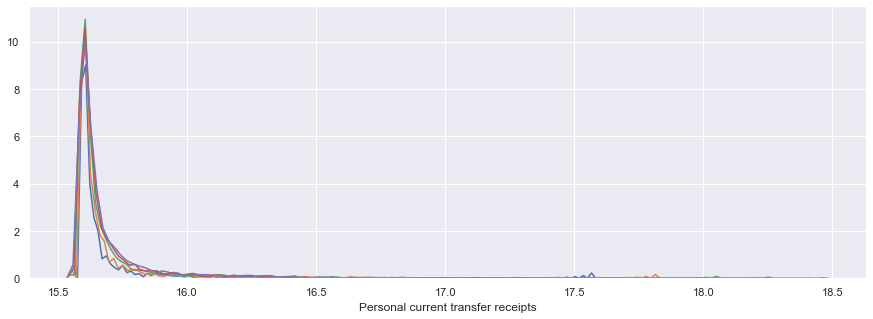

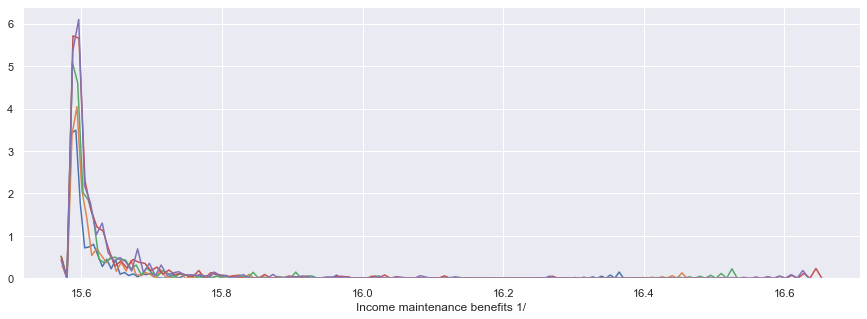

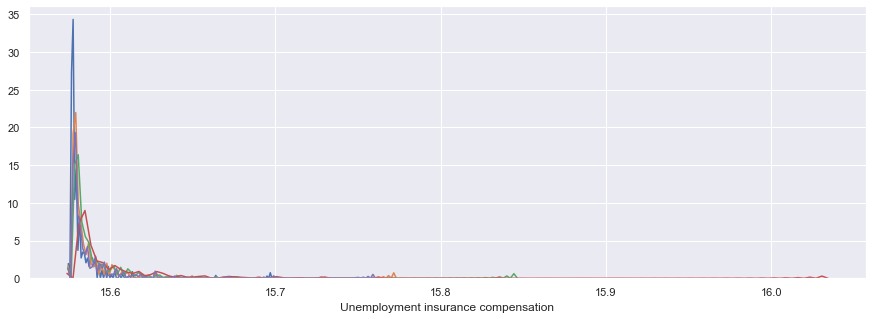

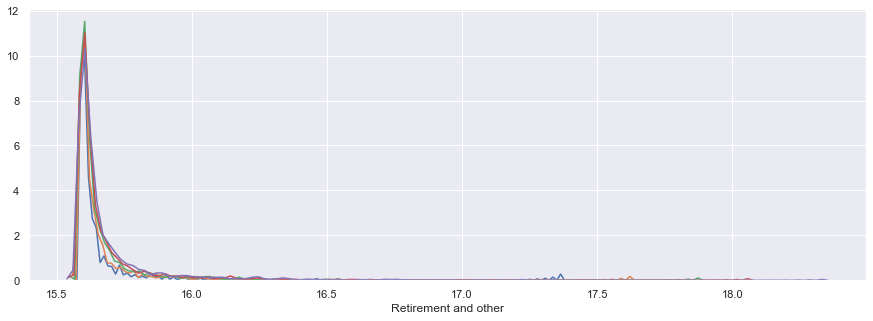

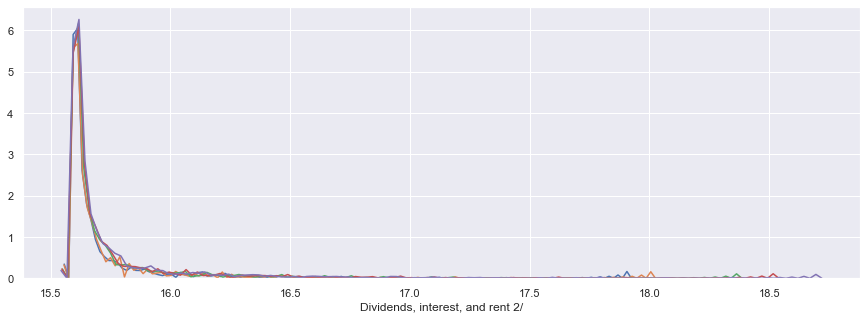

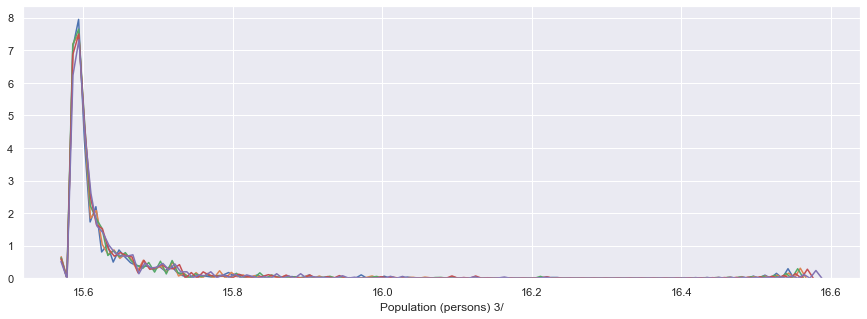

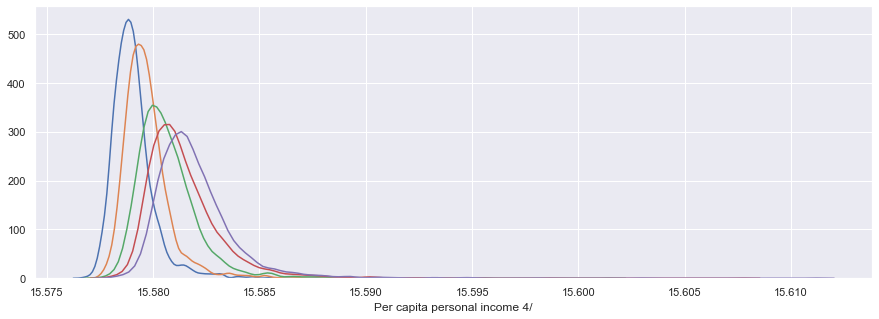

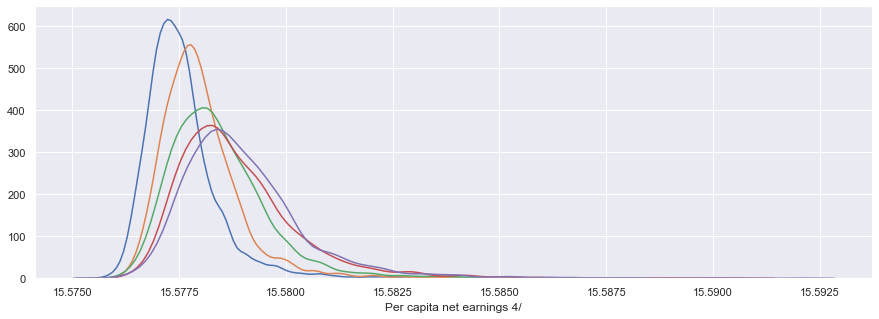

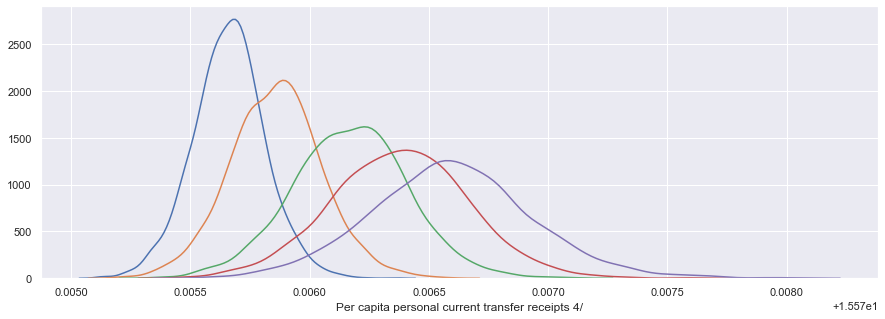

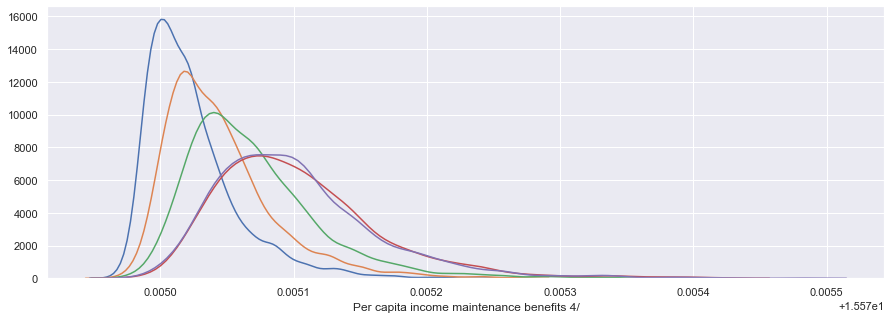

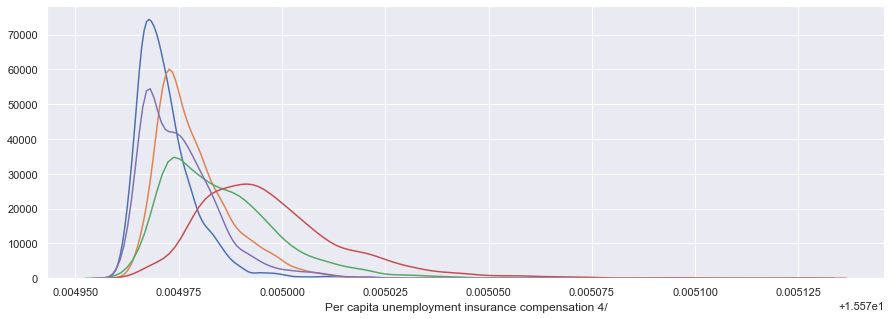

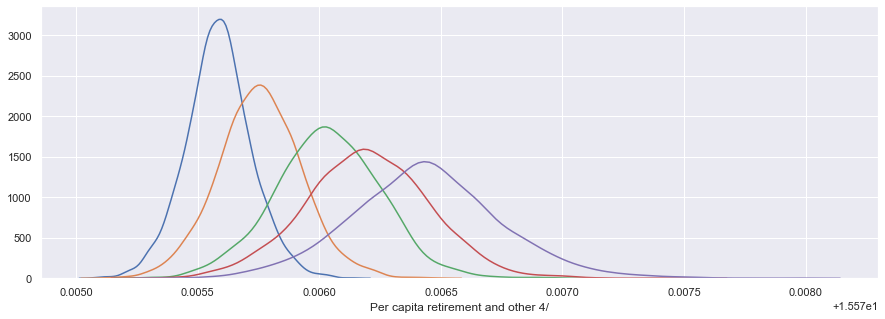

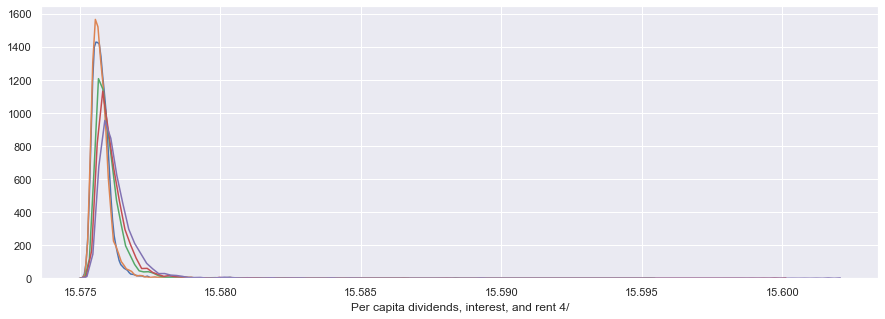

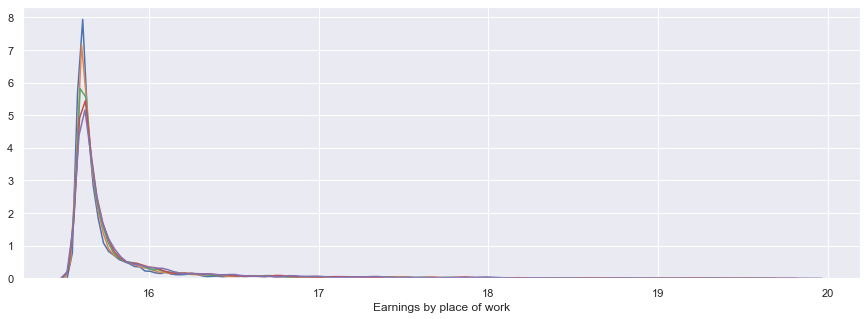

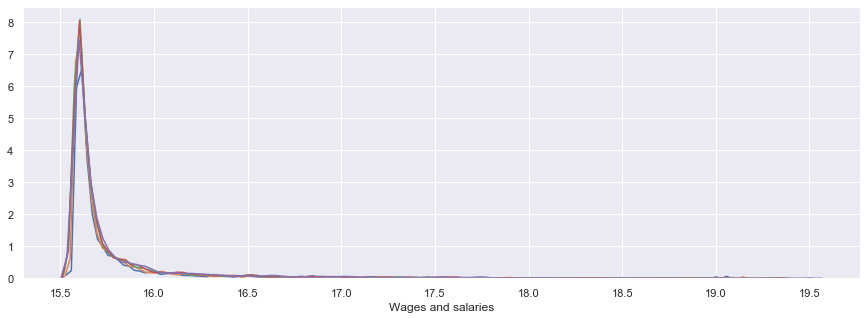

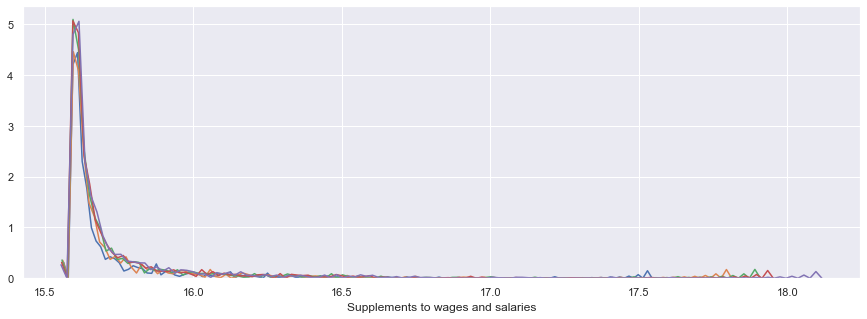

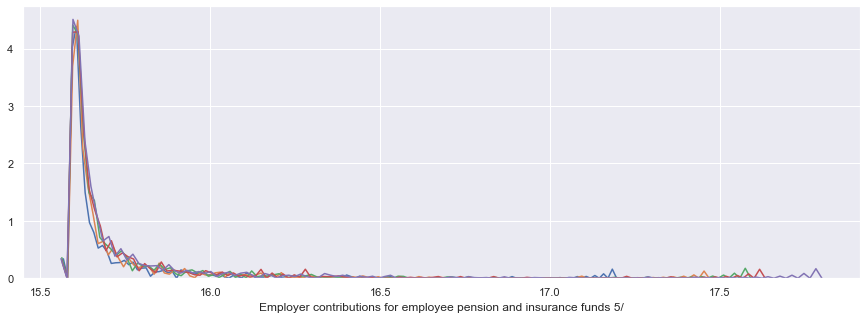

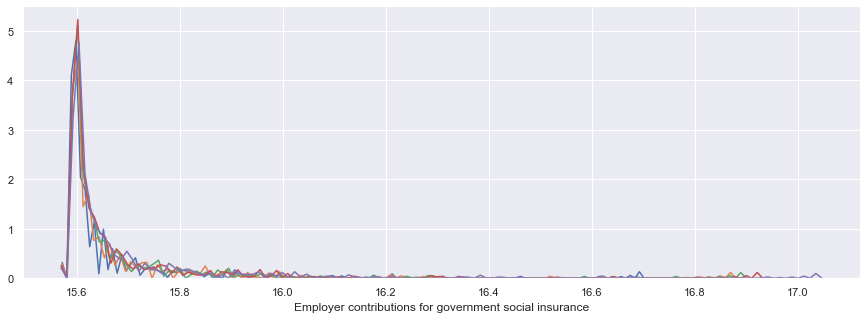

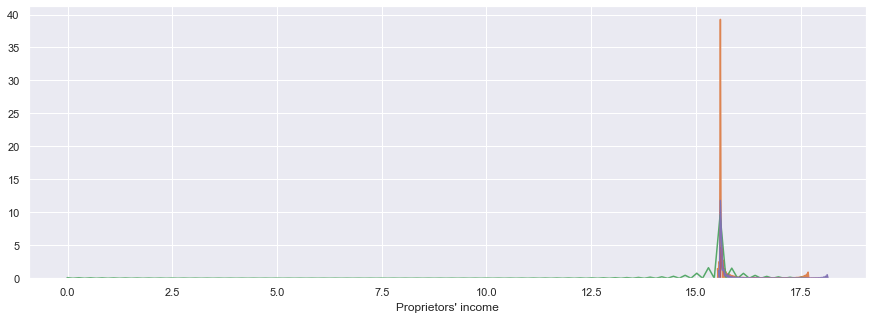

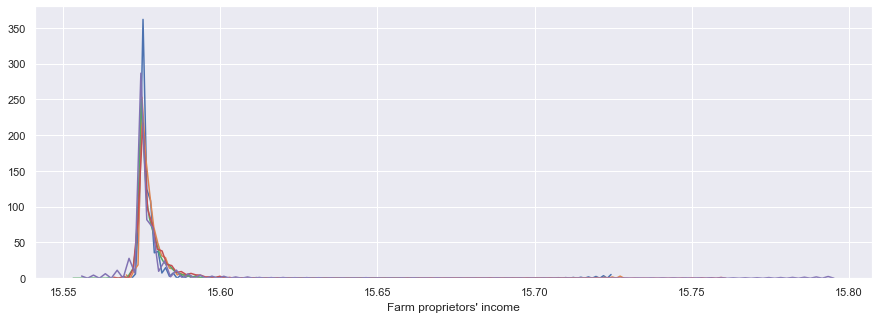

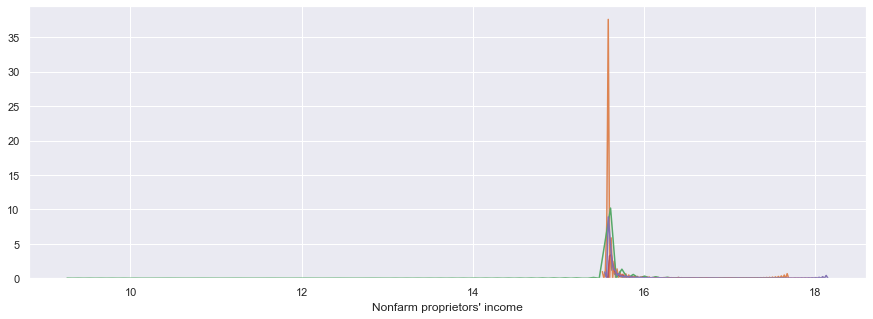

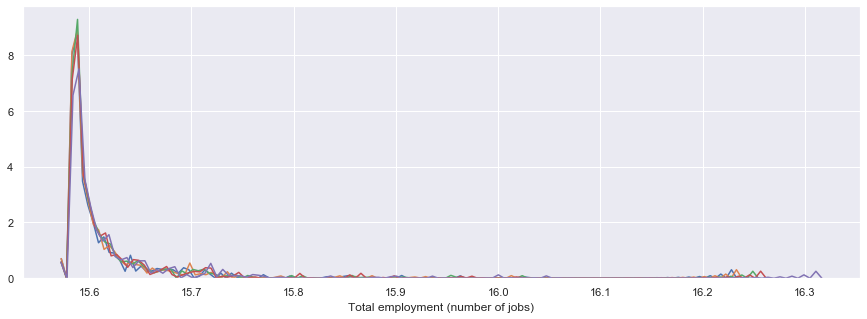

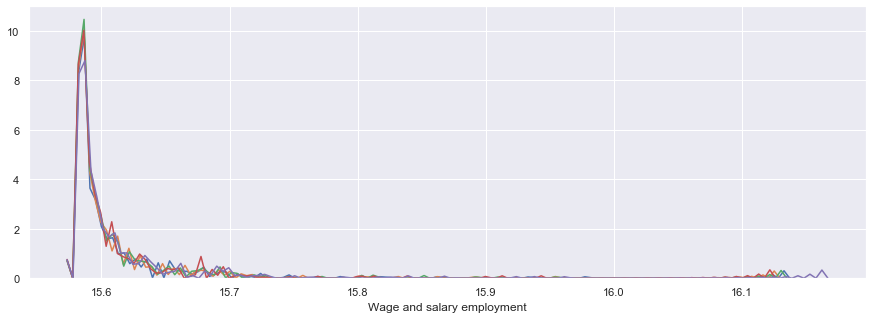

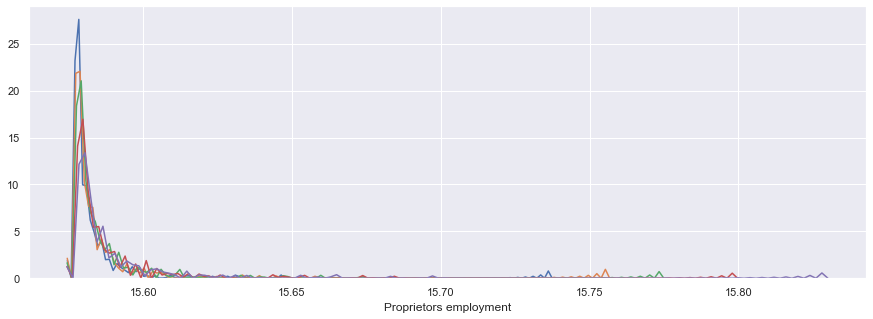

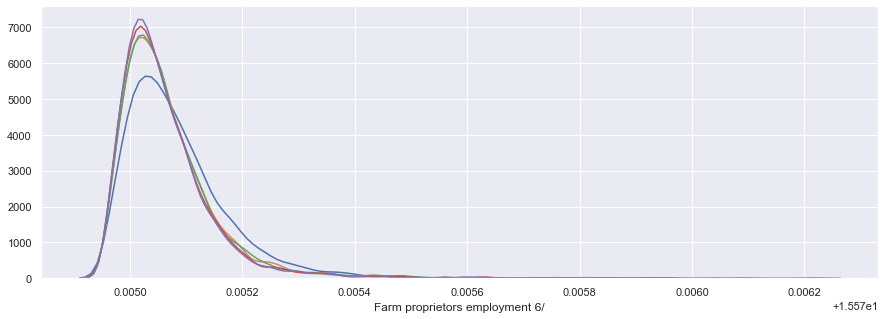

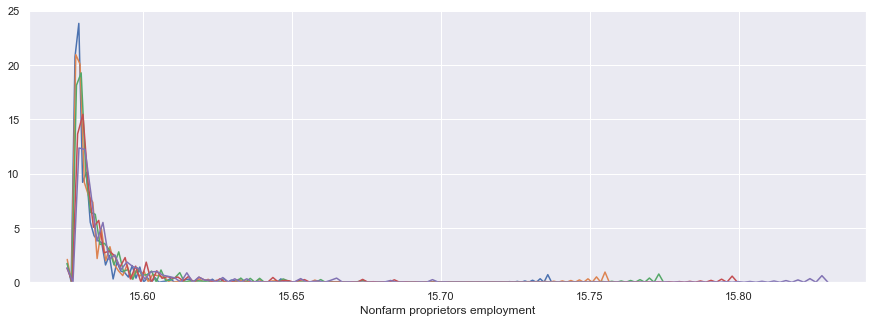

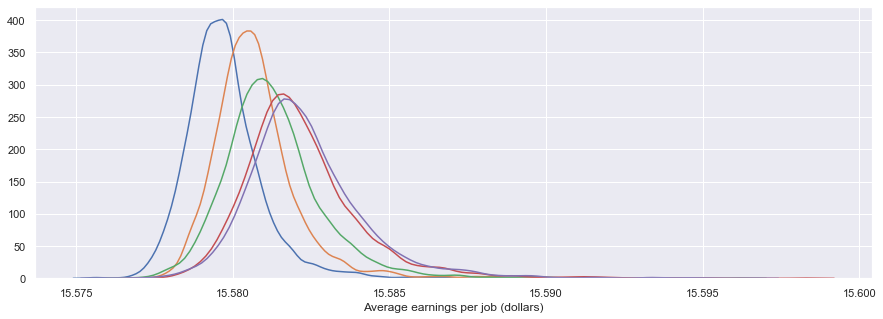

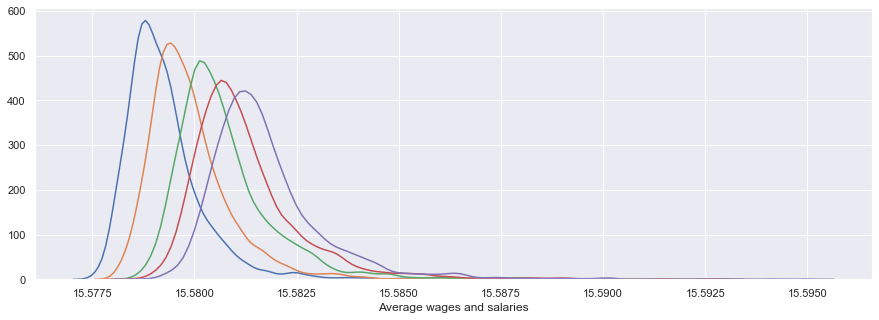

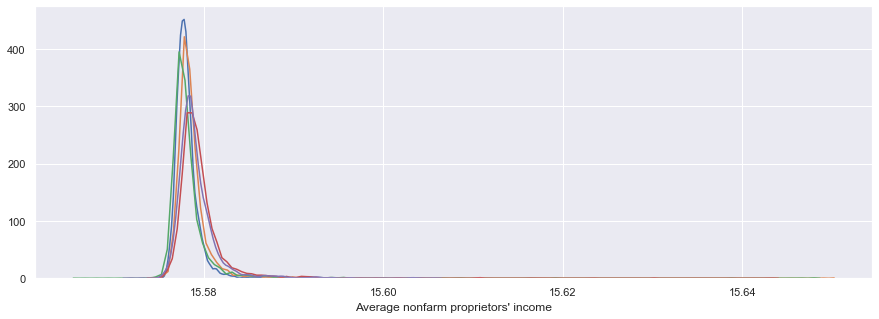

In [9]:
for col in num_cols:
    plt.figure(figsize=(15, 5))
    sns.distplot(df[col][df['year'] == 2000], hist=False)
    sns.distplot(df[col][df['year'] == 2004], hist=False)
    sns.distplot(df[col][df['year'] == 2008], hist=False)
    sns.distplot(df[col][df['year'] == 2012], hist=False)
    sns.distplot(df[col][df['year'] == 2016], hist=False)

In [10]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

,year,state,county,fips,pres,republican,democrat,total_votes,winner,Personal income (thousands of dollars),...,Farm proprietors' income,Nonfarm proprietors' income,Total employment (number of jobs),Wage and salary employment,Proprietors employment,Farm proprietors employment 6/,Nonfarm proprietors employment,Average earnings per job (dollars),Average wages and salaries,Average nonfarm proprietors' income
0,2000,Alabama,Autauga,01001,1,11993.0,4942.0,17208.0,1,-0.289360,...,-0.163619,-0.230897,-0.225361,-0.226009,-0.185860,-0.441936,-0.180295,-0.994804,-0.937187,-0.521287
1,2004,Alabama,Autauga,01001,1,15196.0,4758.0,20081.0,1,-0.203229,...,-0.013472,-0.216305,-0.220915,-0.221066,-0.184348,-0.598632,-0.176691,-0.591744,-0.617200,-0.351739
2,2008,Alabama,Autauga,01001,0,17403.0,6093.0,23641.0,1,-0.084727,...,-0.235699,-0.234829,-0.215445,-0.221138,-0.160159,-0.533994,-0.153323,-0.594751,-0.218707,-0.760064
3,2012,Alabama,Autauga,01001,0,17379.0,6363.0,23932.0,1,-0.036808,...,-0.266167,-0.197887,-0.223674,-0.229155,-0.167066,-0.557499,-0.159929,-0.204376,0.117787,-0.283247
4,2016,Alabama,Autauga,01001,1,18172.0,5936.0,24973.0,1,0.031509,...,-0.348258,-0.188491,-0.217655,-0.224450,-0.157813,-0.579045,-0.150373,0.032022,0.434211,-0.264082


In [11]:
#data = df[df.columns.difference(info_cols + elec_cols)].values

#scaler = StandardScaler()
#data = scaler.fit_transform(data)

In [12]:
data = df[df.columns.difference(info_cols + elec_cols[:-1])].values
row_years = dict(zip(df['year'].unique(),
                     map(lambda x: df[df['year'] == x].index,
                         df['year'].unique())))

data_per_year = list(map(lambda x: data[x, :], list(row_years.values())))

### Mapper

#### SVD Filter

In [13]:
n_components = 1

nintervals = 10
overlap = 0.9

method = 'complete'
metric = 'correlation'
cutoff = FirstGap(0.2)

filtr = SvdFilter(n_components=n_components)

##### 2000

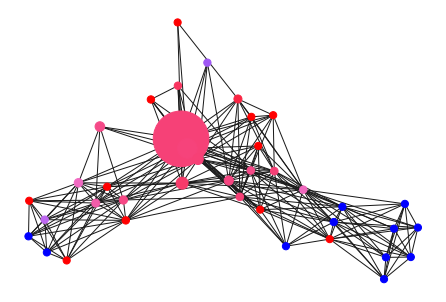

In [14]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[0])
mapper.fit(verbose=0)

nx_plot_mapper(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='winner'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

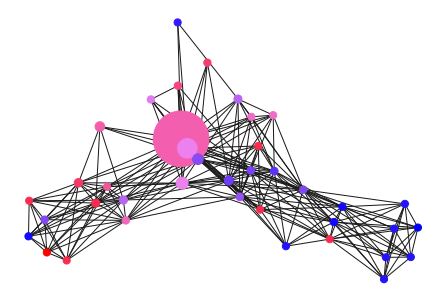

In [15]:
nx_plot_mapper(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='Per capita net earnings 4/'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

In [16]:
map_col = (pd.DataFrame(np.zeros((data_per_year[0].shape[0],
                                  2)),
                        columns=['color_sum', 'n_counties'])
           .astype({'n_counties': 'int'}))
map_col.head()

,color_sum,n_counties
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0


##### 2004

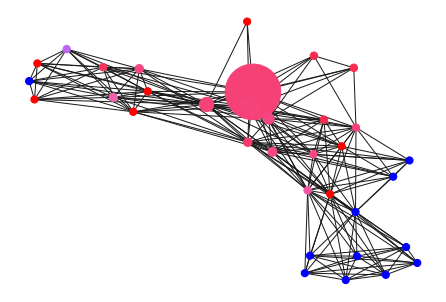

In [17]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[1])
mapper.fit(verbose=0)

nx_plot_mapper(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='winner'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2008

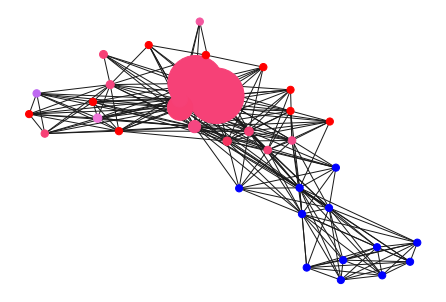

In [18]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[2])
mapper.fit(verbose=0)

nx_plot_mapper(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='winner'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2012

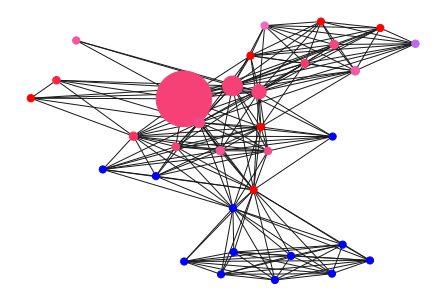

In [19]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[3])
mapper.fit(verbose=0)

nx_plot_mapper(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='winner'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2016

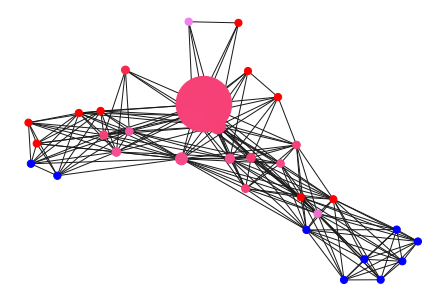

In [20]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[4])
mapper.fit(verbose=0)

nx_plot_mapper(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='winner'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

<hr style="border: 1px dashed rgb(255,255,255)" color=rgb(0,0,0) size="6">

#### Projection

In [21]:
ax = 1

nintervals = 5
overlap = 0.9

method = 'complete'
metric = 'correlation'
cutoff = FirstGap(.2)

filtr = Projection(ax=ax)

##### 2000

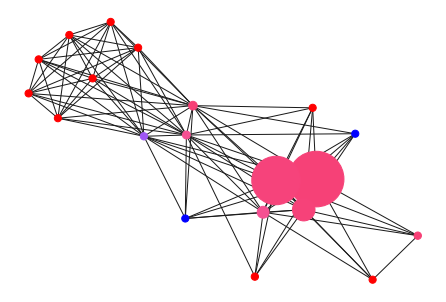

In [22]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[0])
mapper.fit(verbose=0)

nx_plot_mapper(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='winner'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2004

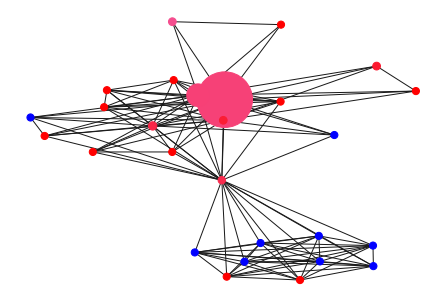

In [23]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[1])
mapper.fit(verbose=0)

nx_plot_mapper(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='winner'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2008

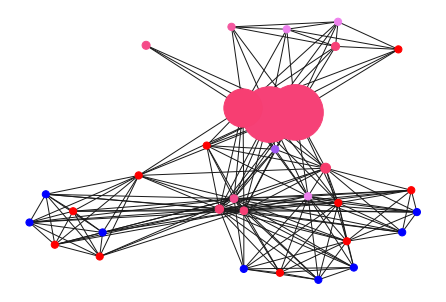

In [24]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[2])
mapper.fit(verbose=0)

nx_plot_mapper(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='winner'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2012

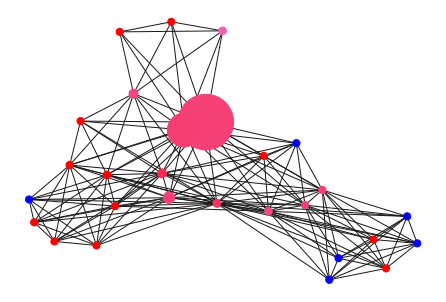

In [25]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[3])
mapper.fit(verbose=0)

nx_plot_mapper(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='winner'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2016

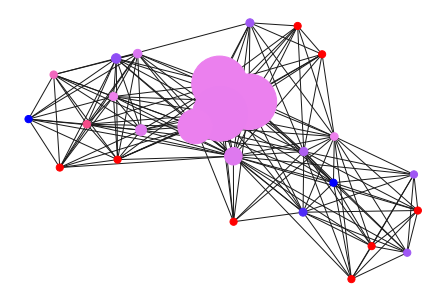

In [26]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[4])
mapper.fit(verbose=0)

nx_plot_mapper(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='winner'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

<hr style="border: 1px dashed rgb(255,255,255)" color=rgb(0,0,0) size="6">

#### $L^p$ Filter

In [27]:
p = 2
k = 1

nintervals = 10
overlap = 0.9

method = 'complete'
metric = 'correlation'
cutoff = FirstGap(0.2)

filtr = LpFilter(p, k)

##### 2000

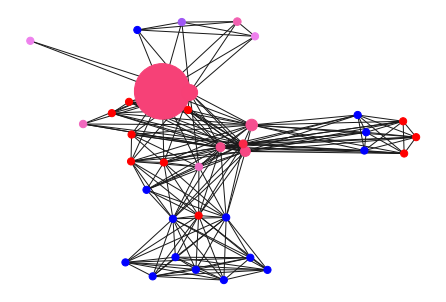

In [28]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[0])
mapper.fit(verbose=0)

nx_plot_mapper(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='winner'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2004

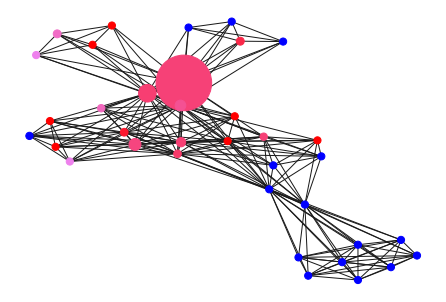

In [29]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[1])
mapper.fit(verbose=0)

nx_plot_mapper(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='winner'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2008

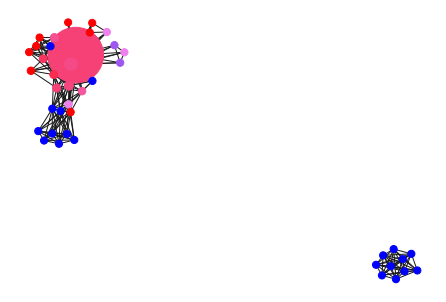

In [30]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[2])
mapper.fit(verbose=0)

nx_plot_mapper(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='winner'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2012

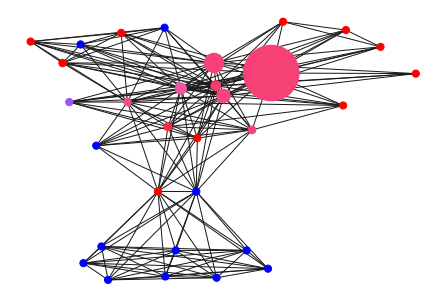

In [31]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[3])
mapper.fit(verbose=0)

nx_plot_mapper(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='winner'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2016

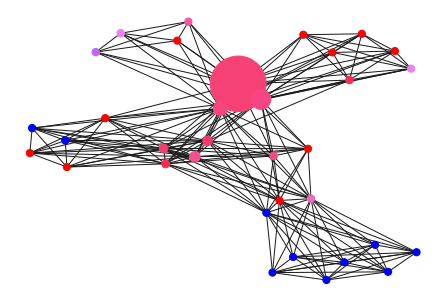

In [32]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[4])
mapper.fit(verbose=0)

nx_plot_mapper(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='winner'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))